# Augmentations

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import albumentations

from sklearn import metrics
from sklearn import model_selection

import torch
import torch.nn as nn
import torch.nn.functional as F

import config
import dataset
import engine
import models

In [4]:
df = pd.read_csv(config.TRAIN_CSV)

In [5]:
augs = albumentations.Compose(
    [
        albumentations.ShiftScaleRotate(
            shift_limit=0.0625,
            scale_limit=0.1,
            rotate_limit=10,
            p=0.9,
        ),
        albumentations.Normalize(config.MEAN, config.STD, max_pixel_value=255.0, always_apply=True),
    ]
)

In [6]:
images = df[config.PIXEL_COLS].values.reshape(-1, 28, 28)

In [7]:
np.mean(images / 255.0), np.std(images / 255.0)

(0.14296817848233043, 0.2537516572364304)

In [8]:
idx = 5
image = images[idx]
image = image.astype(np.uint8)
# image = Image.fromarray(image)
# image = image.convert("RGB")

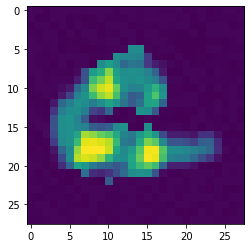

In [9]:
plt.imshow(image);

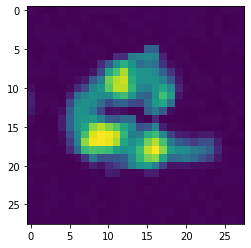

In [10]:
augmented = augs(image=image)
aug_image = augmented["image"]
plt.imshow(aug_image);

## Train

In [11]:
device = torch.device(config.DEVICE)

In [12]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, stratify=df.digit)
train_loader = dataset.get_dataloader(df_train, augs=augs)
valid_loader = dataset.get_dataloader(df_valid, train=False)

In [13]:
model = models.Model()
model.to(device)

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(13, 13))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_3): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(11, 11))
  (bn2_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(64, 128, kernel_size=(4, 4

In [43]:
optimizer = torch.optim.Adam(model.parameters())
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: 1e-3 * 0.95 ** x)

In [44]:
best_epoch = 0
best_accuracy = 0
early_stopping_counter = 0

for epoch in range(config.EPOCHS):
    engine.train(train_loader, model, optimizer, device)
    predictions, targets = engine.evaluate(valid_loader, model, device)
#     scheduler.step()

    predictions = np.array(predictions)
    predictions = np.argmax(predictions, axis=1)
    accuracy = metrics.accuracy_score(targets, predictions)
    
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        best_epoch = epoch
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    if early_stopping_counter > config.PATIENCE:
        break

    print(f"Epoch: {epoch}, Accuracy={accuracy}")
    
print(f"Best Epoch: {best_epoch}, Best Accuracy={best_accuracy}")

Epoch: 0, Accuracy=0.3170731707317073
Epoch: 1, Accuracy=0.43414634146341463
Epoch: 2, Accuracy=0.4634146341463415
Epoch: 3, Accuracy=0.5317073170731708
Epoch: 4, Accuracy=0.4878048780487805
Epoch: 5, Accuracy=0.5121951219512195
Epoch: 6, Accuracy=0.5804878048780487
Epoch: 7, Accuracy=0.6146341463414634
Epoch: 8, Accuracy=0.5219512195121951
Epoch: 9, Accuracy=0.5707317073170731
Epoch: 10, Accuracy=0.6292682926829268
Epoch: 11, Accuracy=0.6731707317073171
Epoch: 12, Accuracy=0.6731707317073171
Epoch: 13, Accuracy=0.6341463414634146
Epoch: 14, Accuracy=0.6926829268292682
Epoch: 15, Accuracy=0.6682926829268293
Epoch: 16, Accuracy=0.7170731707317073
Epoch: 17, Accuracy=0.6926829268292682
Epoch: 18, Accuracy=0.6634146341463415
Epoch: 19, Accuracy=0.7268292682926829
Epoch: 20, Accuracy=0.6731707317073171
Epoch: 21, Accuracy=0.7365853658536585
Epoch: 22, Accuracy=0.6439024390243903
Epoch: 23, Accuracy=0.7853658536585366
Epoch: 24, Accuracy=0.7804878048780488
Epoch: 25, Accuracy=0.702439024390

In [16]:
torch.save(model.state_dict(), "../models/normalize.pt")

## Inference

In [17]:
model = models.Model()
model.load_state_dict(torch.load("../models/normalize.pt"))

<All keys matched successfully>

In [18]:
model.to(device)

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(13, 13))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_3): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(11, 11))
  (bn2_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(64, 128, kernel_size=(4, 4

In [19]:
df_test = pd.read_csv(config.TEST_CSV)
test_dataset = dataset.InferenceEMNISTDataset(df_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.TEST_BATCH_SIZE)

In [49]:
predictions = engine.infer(test_loader, model, device)
predictions = np.array(predictions)
predictions = np.argmax(predictions, axis=1)

In [50]:
submission = pd.DataFrame({"id": df_test.id, "digit": predictions})
submission.to_csv("../output/early_stopping.csv", index=False)
submission.head()

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
